# Toxic Spans Detection

In this notebook, we will train a model to detect toxic spans in text.

We will use [simpletransformers](https://simpletransformers.ai/) that is a wrapper for many popular models available in [Hugging Face](https://huggingface.co/).

We will use a pre-trained model ([neuralmind/bert-base-portuguese-cased · Hugging Face](https://huggingface.co/neuralmind/bert-base-portuguese-cased)) that is trained on Portuguese.

## Imports

In the first cell, we set the `KAGGLE_USERNAME` and `KAGGLE_KEY` environment variables. We also import the required packages.

In [1]:
import os
import torch
import spacy
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from typing import List, Dict, Any
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split

%matplotlib inline

seed = 1993

In the next cell, we will remove some folders used by `simpletransformers`.

In [2]:
temp_folders = ["cache_dir", "outputs", "runs"]

for folder in temp_folders:
    if os.path.exists(folder):
        shutil.rmtree(folder, ignore_errors=True)

## Functions

In this section, we will define some helper functions.

In [3]:
def get_toxic_substrings(text: str, spans: List[int]) -> List[str]:
    """
    Extract string words based on a list of spans.

    Args:
    - text: The text to extract words from.
    - spans: A list of spans to extract words from.

    Returns:
    - A list of words extracted from the text.
    """
    def format_substring(substring: str):
        return " ".join("".join(substring).split())

    delimiter = None
    words = []
    tmp = []
    for i in range(len(text)):
        if i in spans:
            if delimiter is None:
                delimiter = i
            else:
                delimiter += 1
            tmp.append(text[i])
        else:
            tmp.append(" ")

        if delimiter is not None and i != delimiter:
            words.append(format_substring(tmp))
            tmp = []
            delimiter = None

    if len(tmp) > 0:
        words.append(format_substring(tmp))
        
    words = [w for w in words if w not in [" ", ""]]
    return words

def get_idx_substrings(text: str, substrings: List[str]) -> List[int]:
    """
    Get the indexes of all substrings in text.

    Args:
    - text: the text to search in
    - substrings: the substrings to search for

    Returns:
    - a list of indexes of all substrings in text
    """
    import re
    idx_substrings = []
    for substring in substrings:
        idx_substrings.extend(
            [(m.start(), m.end()) for m in re.finditer(substring, text)]
        )
    return idx_substrings

def get_doc_spans(text: str, spans: List[int], spans_key: str = "sc",
                  nlp: spacy.language.Language = None) -> List[spacy.tokens.doc.Doc]:
    """
    Get the spans of all substrings in text.

    Args:
    - text: the text to search in
    - spans: the spans to search for
    - nlp: the spacy language model to use

    Returns:
    - a list of spacy.Doc annotated spans of all substrings in text
    """
    if nlp is None:
        nlp = spacy.load("pt_core_news_lg")

    substrs = get_toxic_substrings(text, spans)
    idx_substrs = get_idx_substrings(text, substrs)
    
    doc = nlp(text)
    toxic_spans = []
    
    for idx_start, idx_end in idx_substrs:
        toxic_spans.append(doc.char_span(idx_start, idx_end))
    
    doc.spans[spans_key] = toxic_spans
    
    return doc

## Load the data

In this section, we will download the data and load it into a pandas dataframe.

In [4]:
if not os.path.exists("olidbr.csv"):
    print("Downloading data from Kaggle")
    kaggle = KaggleApi()
    kaggle.authenticate()
    kaggle.dataset_download_file(dataset="olidbr", file_name="olidbr.csv")

df = pd.read_csv("olidbr.csv")

print(f"Shape: {df.shape}")
df.head()

Shape: (711, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,6391e3dbb12848ac8ef6131edf2d69f9,USER Canalha URL,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12]",False,False,True,False,False,False,False,False,False,False,False
1,5a21508c2afc4c3295137451baf8b981,USER VTNSC FDP,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12, 13]",False,False,True,False,False,False,True,False,False,False,False
2,060b0390f99041cd8cd38ca5a2b66907,USER O partido do Kim votou à favor do fundão....,OFF,TIN,IND,NaN,False,False,True,False,False,False,False,False,False,False,False
3,3264fc0b06974c2daf423a9e5998d003,USER Grande homem. Em um país de covardes. Ete...,OFF,TIN,GRP,"[34, 35, 36, 37, 38, 39, 40, 41]",False,False,True,False,False,False,False,False,False,False,False
4,002bced1b7444833bbe5e054c5aa6512,USER USER QAnon Brasil é um bicho estranho. Ob...,OFF,TIN,IND,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...",False,False,True,False,False,False,True,False,False,False,False


In [5]:
print(f"Comments with spans assigned: {df[df.toxic_spans.notnull()].shape[0]} ({df[df.toxic_spans.notnull()].shape[0] / df.shape[0] * 100:.2f}%)")
print(f"Comments without spans assigned: {df[df.toxic_spans.isnull()].shape[0]} ({df[df.toxic_spans.isnull()].shape[0] / df.shape[0] * 100:.2f}%)")

Comments with spans assigned: 284 (39.94%)
Comments without spans assigned: 427 (60.06%)


We need to filter out the comments that do not have a toxic span.

In [6]:
df = df[df["toxic_spans"].notnull()]
df.reset_index(drop=True, inplace=True)

df["toxic_spans"] = df["toxic_spans"].apply(lambda x: eval(x))

print(f"Shape: {df.shape}")

Shape: (284, 17)


## Explorative analysis

In the second cell, we load the data and perform an exploratory analysis.

toxic_substrs: 376


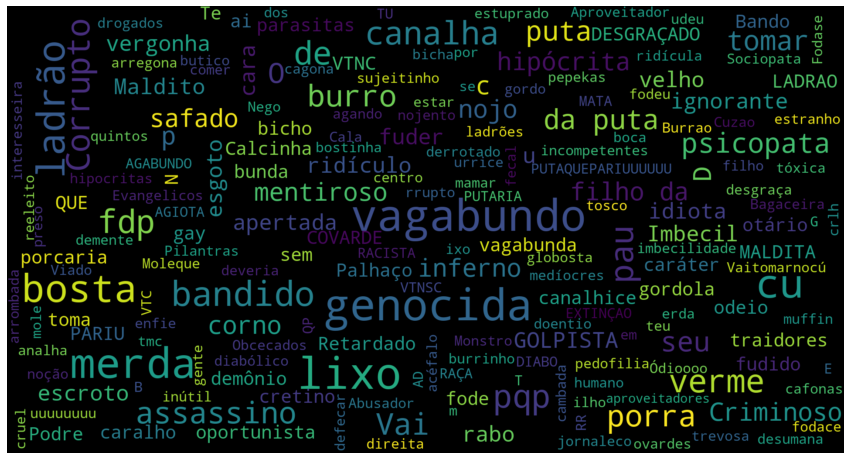

In [7]:
toxic_substrs = []

for row in df.to_dict(orient="records"):
    if row.get("toxic_spans") is not None:
        toxic_substrs.extend(get_toxic_substrings(row["text"], row["toxic_spans"]))

print(f"toxic_substrs: {len(toxic_substrs)}")

wc = WordCloud(width=1920, height=1024,
               max_words=200, max_font_size=100)

wc.generate(" ".join(toxic_substrs))

plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Prepare the data

In this section, we will prepare the data in order to train the model.

The `simpletransformers` library expects the data in a specific format.

More information about the format can be found in the [Classification Data Formats - Simple Transformers](https://simpletransformers.ai/docs/classification-data-formats/#binary-classification)

In [8]:
df = df[["text", "toxic_spans"]]

X = df["text"].values
y = df["toxic_spans"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=seed)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (198,)
X_test shape: (86,)


## Training the model

In this section, we will train a baseline model to predict if a toxic comment is targeted or not.

We will not perform hyperparameter tuning because it is a simple baseline model.

In [28]:
from thinc.api import Config

spacy_config = """
[paths]
train = null
dev = null
vectors = null
init_tok2vec = null

[system]
gpu_allocator = "pytorch"
seed = 0

[nlp]
lang = "pt"
pipeline = ["transformer","spancat"]
batch_size = 128
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}

[components]

[components.spancat]
factory = "spancat"
max_positive = null
scorer = {"@scorers":"spacy.spancat_scorer.v1"}
spans_key = "sc"
threshold = 0.5

[components.spancat.model]
@architectures = "spacy.SpanCategorizer.v1"

[components.spancat.model.reducer]
@layers = "spacy.mean_max_reducer.v1"
hidden_size = 128

[components.spancat.model.scorer]
@layers = "spacy.LinearLogistic.v1"
nO = null
nI = null

[components.spancat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
grad_factor = 1.0
pooling = {"@layers":"reduce_mean.v1"}
upstream = "transformer"

[components.spancat.suggester]
@misc = "spacy.ngram_suggester.v1"
sizes = [1,2,3]

[components.transformer]
factory = "transformer"
max_batch_items = 4096
set_extra_annotations = {"@annotation_setters":"spacy-transformers.null_annotation_setter.v1"}

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "neuralmind/bert-base-portuguese-cased"
mixed_precision = false

[components.transformer.model.get_spans]
@span_getters = "spacy-transformers.strided_spans.v1"
window = 128
stride = 96

[components.transformer.model.grad_scaler_config]

[components.transformer.model.tokenizer_config]
use_fast = true

[components.transformer.model.transformer_config]

[corpora]

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0
gold_preproc = false
limit = 0
augmenter = null

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0
gold_preproc = false
limit = 0
augmenter = null

[training]
accumulate_gradient = 3
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"
seed = ${system.seed}
gpu_allocator = ${system.gpu_allocator}
dropout = 0.1
patience = 1600
max_epochs = 0
max_steps = 20000
eval_frequency = 200
frozen_components = []
annotating_components = []
before_to_disk = null

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 2000
buffer = 256
get_length = null

[training.logger]
@loggers = "spacy.ConsoleLogger.v1"
progress_bar = false

[training.optimizer]
@optimizers = "Adam.v1"
beta1 = 0.9
beta2 = 0.999
L2_is_weight_decay = true
L2 = 0.01
grad_clip = 1.0
use_averages = false
eps = 0.00000001

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 250
total_steps = 20000
initial_rate = 0.00005

[training.score_weights]
spans_sc_f = null
spans_sc_p = null
spans_sc_r = null
spans_grit_f = 1.0
spans_grit_p = 0.0
spans_grit_r = 0.0

[pretraining]

[initialize]
vectors = ${paths.vectors}
init_tok2vec = ${paths.init_tok2vec}
vocab_data = null
before_init = null
after_init = null

[initialize.lookups]
@misc = "spacy.LookupsDataLoader.v1"
lang = ${nlp.lang}
tables = ["lexeme_norm"]

[initialize.components]

[initialize.tokenizer]

"""

cfg = Config().from_str(spacy_config)
cfg

{'components': {'spancat': {'factory': 'spancat',
   'max_positive': None,
   'scorer': {'@scorers': 'spacy.spancat_scorer.v1'},
   'spans_key': 'sc',
   'threshold': 0.5,
   'model': {'@architectures': 'spacy.SpanCategorizer.v1',
    'reducer': {'@layers': 'spacy.mean_max_reducer.v1', 'hidden_size': 128},
    'scorer': {'@layers': 'spacy.LinearLogistic.v1', 'nO': None, 'nI': None},
    'tok2vec': {'@architectures': 'spacy-transformers.TransformerListener.v1',
     'grad_factor': 1.0,
     'pooling': {'@layers': 'reduce_mean.v1'},
     'upstream': 'transformer'}},
   'suggester': {'@misc': 'spacy.ngram_suggester.v1', 'sizes': [1, 2, 3]}},
  'transformer': {'factory': 'transformer',
   'max_batch_items': 4096,
   'set_extra_annotations': {'@annotation_setters': 'spacy-transformers.null_annotation_setter.v1'},
   'model': {'@architectures': 'spacy-transformers.TransformerModel.v3',
    'name': 'neuralmind/bert-base-portuguese-cased',
    'mixed_precision': False,
    'get_spans': {'@span

In [29]:
spacy.prefer_gpu()

nlp = spacy.load("pt_core_news_lg")

model = spacy.util.load_model_from_config(cfg, validate=True)

In [30]:
examples = []

with tqdm(total=len(X_train)) as pbar:
    pbar.set_description("Loading training examples")
    for x, y in zip(X_train, y_train):
        examples.append(get_doc_spans(x, y, nlp=nlp))
        pbar.update()

examples = [spacy.training.Example(predicted=e, reference=e) for e in examples]

Loading training examples: 100%|██████████| 198/198 [00:03<00:00, 60.34it/s]


In [31]:
model.initialize(lambda: examples)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ValueError: [E143] Labels for component 'spancat' not initialized. This can be fixed by calling add_label, or by providing a representative batch of examples to the component's `initialize` method.

Object `model.predict` not found.


## Evaluating the model

In this section, we will evaluate the model with the following metrics:

- **Accuracy**: the percentage of correct predictions;
- **Precision**: the percentage of predicted targeted comments that are actually targeted;
- **Recall**: the percentage of targeted comments that are actually predicted as targeted;
- **F1-Score**: the harmonic mean of precision and recall;

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(df_test)

y_true = df_test["labels"].tolist()

y_pred, raw_outputs = model.predict(df_test["text"].tolist())

In [ ]:
print(classification_report(y_true, y_pred, digits=4,
                            target_names=classes.values()))

## Testing the model

In the last section, we will test the model with some comments from the test set.

In [ ]:
df_pred = df_test.head(20)

predictions, raw_outputs = model.predict(df_pred["text"].tolist())

df_pred = df_pred.assign(predictions=predictions)

df_pred["labels"] = df_pred["labels"].map(classes)
df_pred["predictions"] = df_pred["predictions"].map(classes)

df_pred